# "MicroMouse" : Motor and Battery Selection

Below is an analysis used to determine a suitable motor for a robot designed for Dr. MacIver's lab. The intention of this robot is to act as a predeator and chase mice around a habit.
***

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import csv

## Design Contraints / Requirements

The robot will operate a hexagonal shapped habit with vinyl flooring that is ~3m in length across longest vertices and has various hexagonal shaped obstacles. Ideally, the robot will fit through the smallest potential opening, which given the obstacle spacing is a litte larger than 6cm. 

The mice move up to 1.7 m/s. If possible we would like the robot to move around 3 m/s, but at minimum it should be quicker than the mice, so at least 2 m/s linearly. The micromouse robots use cornering speed around 1 m/s and turn between 60 and 120 degrees.  

## Electrical motor specs

In order to derive the equations that govern a motor's behavior,  we first have to look at the electrical specs. The electrical power is going to be out input power after all, and the output power will be the mechanical power. 

Simply put, the input electrical power is...
 
$P_e = IV$

*Where I is current and V is Votlage*

However, this Input Power has to account for the Mechanical Output Power ($\tau\omega$) as well as power lost through heat dissipation and such. Therefore...

$IV = (\tau_{out} G)(\frac{\omega_{out}}{G}) + {I}^2 R + LI \frac{dI}{dt}$

*Where $G$ is the gear reduction*

Dividing by $I$ we can get an equation for the Voltage:

$V = \frac{\tau_{out}G}{I} (\frac{\omega_{out}}{G}) + IR + L \frac{dI}{dt}$


$\frac{\tau}{I}$ is a constant value, given Lorentz force law. This constant is called the torque constant $k_t$

$k_t = \frac{\tau}{I}$

$k_t G = \frac{\tau_{out}G}{I}$

$\tau_{out} = \frac{k_t I}{G}$

Rewrite the Voltage equation to incorparate the torque constant...

$V = k_t G \frac{\omega_{out}}{G} + IR + L \frac{dI}{dt}$

Going back to the Speed-Torque curve, we can assume that at a constant speed and constant torque the Voltage equation is reduced to...

$V = k_t G \frac{\omega_{out}}{G} + IR $

Solving for $\omega$ ...

$\omega = \frac{1}{k_t} V - \frac{R}{{k_t}^2} \tau$

Here, we can calculate the no load speed and stall torque given the electrical specs of the motor

$\omega_0 = \frac{V}{k_t}$

$\tau_s = \frac{k_t V}{R}$

## "RACE" SIMULATIONS

Considering that the motors have variable acceleration and velocities, perhaps the best place to start comparing motors is by simulaitng a "race" with various motors. These simulaitons only take into account motor parameters such as the torque constant $k_t$, voltage $V$, a motor's resistance $R$ and so on, parameters which we used in the governing equations above.  


Given the electrical input power equations above, we solved for $\omega$ given a motor's torque constant, voltage and resistance...

$\omega = \frac{1}{k_t} V - \frac{R}{{k_t}^2} \tau$

Now lets rearrange this equation to solve for torque:

$\omega - \frac{1}{k_t} V = - \frac{R}{{k_t}^2} \tau$

$\frac{R}{{k_t}^2} \tau = \frac{1}{k_t} V - \omega$

$R \tau = V k_t - \omega {k_t}^2$

$\tau = \frac{V k_t - \omega {k_t}^2}{R} = \frac{k_t(V - \omega k_t)}{R}$

Assuming a 100% effiecent motor, we can use these mechanical eqautions...

$F = ma$

$\tau = Fr = mar$

$v = \omega r$

$\omega = \frac{v}{r}$


Sub the appropriate equations into $\tau$ and $\omega$...

$\tau = \frac{V k_t - \omega {k_t}^2}{R} = \frac{k_t(V - \omega k_t)}{R}$

$mar = \frac{V k_t - \frac{v}{r} {k_t}^2}{R} = \frac{V k_t}{R} - \frac{v {k_t}^2}{Rr}$

$a = \frac{V k_t}{Rmr} - \frac{v {k_t}^2}{Rm{r}^2}$

$0 = a + \frac{v {k_t}^2}{Rm{r}^2} - \frac{V k_t}{Rmr} $


Now that we've elimated torque and radial velocity from our equation, we have a function that is governed by two non-constant vairbles, acceleration $a$ and linear velocity $v$. Fortunately, both these varibales can be represented by 2nd and 1st order differentials of displacement over time (respectively). Now lets represent our funciton as only dependent on displacement over time....

$\frac{{d}^2 x}{d{t}^2} + \frac{\frac{dx}{dt} {k_t}^2}{Rm{r}^2} - \frac{V k_t}{Rmr} = 0$


Eliminate the constant value so we can solve for a solution:

$\frac{{d}^2 x}{d{t}^2} + \frac{{k_t}^2 \frac{dx}{dt}}{Rm{r}^2} = 0$


Assume the solution will be porpoertional to ${e}^{\lambda t}$ and sub $x(t)= {e}^{\lambda t}$ into the diff eq:

$\frac{{d}^2}{d{t}^2} {e}^{\lambda t} + \frac{{k_t}^2 \frac{d}{dt} {e}^{\lambda t}}{Rm{r}^2} = 0$

${\lambda}^2 {e}^{\lambda t} + \frac{{k_t}^2 \lambda {e}^{\lambda t}}{Rm{r}^2} = 0$

$({\lambda}^2 + \frac{{k_t}^2 \lambda}{Rm{r}^2}) {e}^{\lambda t} = 0$


Since ${e}^{\lambda t}$ CANNOT equal 0...

${\lambda}^2 + \frac{{k_t}^2 \lambda}{Rm{r}^2} = 0$

$\frac{\lambda ({k_t}^2 + \lambda Rm{r}^2)}{Rm{r}^2} = 0$


Solving for $\lambda$....

$\lambda = 0$

and

$\lambda = - \frac{{k_t}^2}{Rm{r}^2}$


For complementary solutions a root of $\lambda = 0$ gives $x_1(t) = c_1$

Also a root $\lambda = - \frac{{k_t}^2}{Rm{r}^2}$ gives $x_2(t) = c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}}$

Therefore the general solution is 

$x(t) = x_1 (t) + x_2 (t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}}$


Great! Now determine the particular solution by the method of undetermined coefficients where $x_p(t) = a_1 t$:

$\frac{dx_p(t)}{dt} = \frac{d}{dt}(a_1 t) = a_1$

$\frac{{d}^2 x_p(t)}{d{t}^2} = \frac{{d}^2}{d{t}^2} (a_1 t) = 0$

$\frac{{d}^2 x_p (t)}{d{t}^2} + \frac{{k_t}^2 \frac{d x_p (t)}{dt}}{Rm{r}^2} = \frac{k_t V}{R m r}$

$\frac{{k}^2 a_1}{Rm{r}^2} = \frac{k_t V}{Rmr}$

$a_1 = \frac{rV}{k_t}$

$x_p(t) = \frac{rVt}{k_t}$


Making the general solution:

$x(t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$


Now lets solve with our givens $x(0) = 0$ and $\frac{dx}{dt}(0) = 0$. For t = 0 and x(0) = 0...

$c_1 + c_2 = 0$


Taking the derivative of our general solution we get:

$\frac{dx(t)}{dt} = \frac{rV}{k} - \frac{{k_t}^2 c_2 e^{-\frac{{k_t}^2 t}{Rm{r}^2}}}{Rm{r}^2}$


Subbing in $\frac{dx}{dt}(0) = 0$ for t = 0...

$\frac{rV}{k} - \frac{{k}^2 c_2}{Rm{r}^2} = 0$

$c_2 = \frac{Vm {r}^3 R}{{k}^3}$


Which means...

$c_1 = - \frac{Vm {r}^3 R}{{k}^3}$


Plugging the constants into the general solution:

$x(t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$

$x(t) = - \frac{V Rm {r}^3}{{k}^3} + \frac{VRm {r}^3}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$

$x(t) = rV(- \frac{Rm {r}^2}{{k}^3} + \frac{Rm {r}^2}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{t}{k_t})$

$x(t) = rV( \frac{t}{k_t} + \frac{Rm {r}^2}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} - \frac{Rm {r}^2}{{k}^3})$

$x(t) = \frac{rV( {k_t}^2 t + Rm{r}^2 ({e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} - 1))}{{k_t}^3}$

We know have an equation for displacement over time, which currently is a function of only the wheel radius and time. But there are two more element that have to be taken into consideration: gear reductions and motor efficieny. Luckily, the only varible influcened by a gear reduction anf motor efficieny is $k_t$. This is because...

$k_t = \frac{\tau}{I}$

And if you multiply the torque by the gear reduction $G$ and efficiency $\eta$, then the torque constant $k_t$ must be proportionately scaled. 

$k_t G \eta = \frac{\tau_{out}G \eta}{I}$


**ADD EFFECIENY**

Therefore our final equation that we will be simulating is...

$x(t) = \frac{rV( {(k_t G \eta)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G \eta)}^2 t}{Rm{r}^2}} - 1))}{{(k_t G \eta)}^3}$

Now that we have our simualtion equation, its time t upload the motor information and simualte!

In [2]:
motor_name = [] 
nominal_V = []
nominal_A = [] 
single_motor_weight = [] 
motor_no_load_RPM = [] 
motor_max_t = [] 
motor_stall_t = [] 
motor_R = [] 
motor_kt = [] 
motor_eff = []
motor_diam = []


def read_csv(filename):
    with open(filename) as f:
        # open the csv file
        reader = csv.reader(f)
        for row in reader:
            # read the rows 1 one by one
            motor_name.append(str(row[0]))
            nominal_V.append(float(row[1]))
            nominal_A.append(float(row[2]))
            single_motor_weight.append(float(row[3]))
            motor_no_load_RPM.append(float(row[4]))
            motor_max_t.append(float(row[5]))
            motor_stall_t.append(float(row[6]))
            motor_R.append(float(row[7]))
            motor_kt.append(float(row[8]))
            motor_eff.append(float(row[9]))
            motor_diam.append(float(row[10]))
         
    return motor_name, nominal_V, nominal_A, single_motor_weight, motor_no_load_RPM, motor_max_t, motor_stall_t, motor_R, motor_kt, motor_eff, motor_diam
    

In [3]:
filename_15W = "1.5W_motors_v2.csv"
motor_power_15W = 1.5
all_motor_name_15W, all_nominal_V_15W, all_nominal_A_15W, all_single_motor_weight_15W, all_motor_no_load_RPM_15W, all_motor_max_t_15W, all_motor_stall_t_15W, all_motor_R_15W, all_motor_kt_15W, all_motor_eff_15W, all_motor_diam_15W = read_csv(filename_15W)

filename_2W = "2W_motors_v2.csv"
motor_power_2W = 2
all_motor_name_2W, all_nominal_V_2W, all_nominal_A_2W, all_single_motor_weight_2W, all_motor_no_load_RPM_2W, all_motor_max_t_2W, all_motor_stall_t_2W, all_motor_R_2W, all_motor_kt_2W, all_motor_eff_2W, all_motor_diam_2W = read_csv(filename_2W)

In [4]:
time = np.arange(0,3,0.1)
tile_len = 0.1

def disp_simulation(kt, G, single_motor_m, input_V, motor_R, wheel_rad):
    # kt in mNm/A
    # single_motor_m in g
    # input V in Volts
    # Motor R in ohms
    # wheel_rad in m
    
    disp = []
    
    m_battery_g = 50
    m_controller = 10
    m_encoder = 5
    m_other = 10
    m_kg = ((single_motor_m*2) + m_battery_g + m_controller + m_encoder +  m_other) / 1000
    
    ktG = (kt / 1000) * G
    rV = wheel_rad * input_V
    Rmr2 = motor_R * m_kg * math.pow(wheel_rad, 2)
    
    for t in time:
        ktG2t = (math.pow(ktG, 2)) * t
        expon = math.exp( -ktG2t / Rmr2)
    
        x_t = (rV * (ktG2t + (Rmr2 * (expon - 1)))) / math.pow(ktG, 3)
        disp.append(x_t)
        
    return disp

def vel_simulation(kt, G, single_motor_m, input_V, motor_R, wheel_rad):
    # wheel_rad in mm
    # kt in mNm/A
    # Motor mass in g (add battery and peripherail mass)
    # input V in Volts
    # Motor R in ohms
    
    vel = []
    
    m_battery_g = 50
    m_controller = 10
    m_encoder = 5
    m_other = 10
    m_kg = ((single_motor_m*2) + m_battery_g + m_controller + m_encoder +  m_other) / 1000
    
    ktG = (kt / 1000) * G
    rV = wheel_rad * input_V
    Rmr2 = motor_R * m_kg * math.pow(wheel_rad, 2)
    
    for t in time:
        ktG2 = (math.pow(ktG, 2))
        ktG2t = ktG2  * t
        expon = math.exp( -ktG2t / Rmr2)
    
        v_t = (rV / (math.pow(ktG, 3))) * (ktG2 - (ktG2 * expon))
        vel.append(v_t)
        
    return vel
    

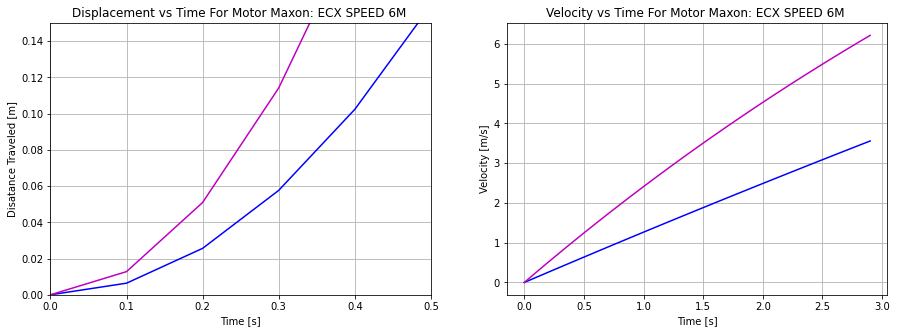

To reach a linear velocity of 3m/s, I need and angular velocity of 375.0 given a wheel radius 0.8cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



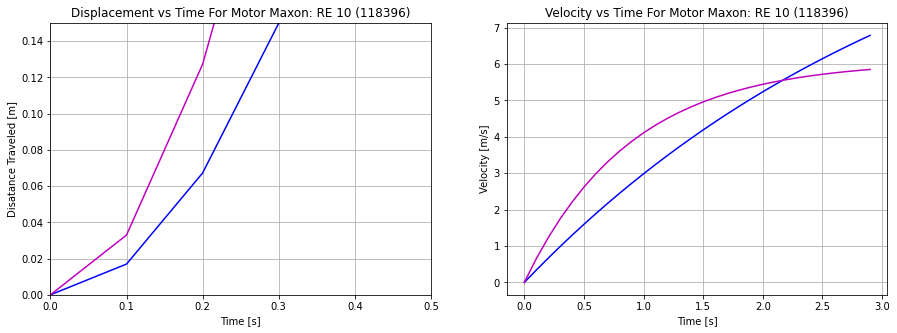

To reach a linear velocity of 3m/s, I need and angular velocity of 300.0 given a wheel radius 1.0cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



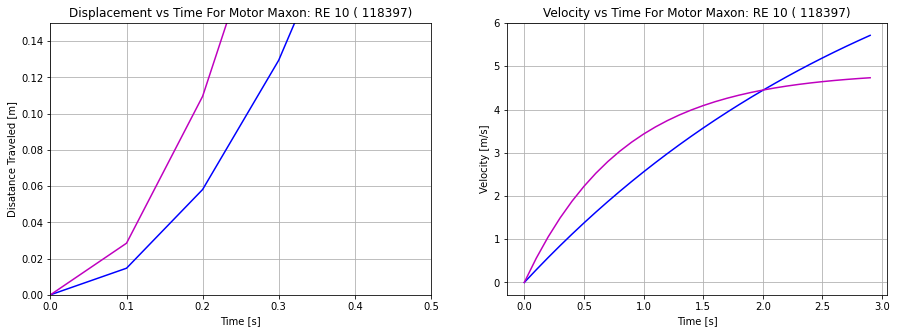

To reach a linear velocity of 3m/s, I need and angular velocity of 300.0 given a wheel radius 1.0cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



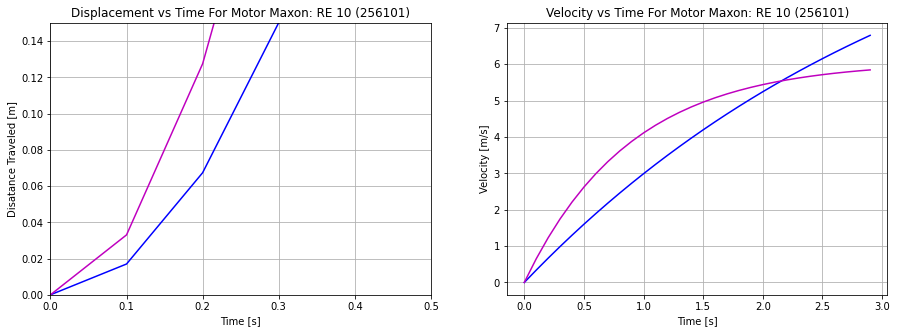

To reach a linear velocity of 3m/s, I need and angular velocity of 300.0 given a wheel radius 1.0cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



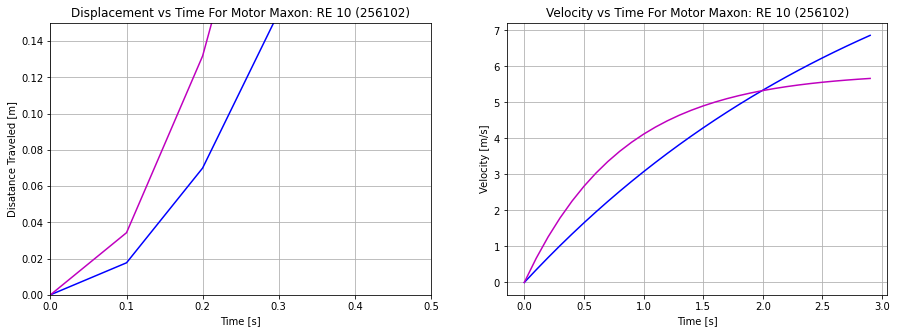

To reach a linear velocity of 3m/s, I need and angular velocity of 300.0 given a wheel radius 1.0cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



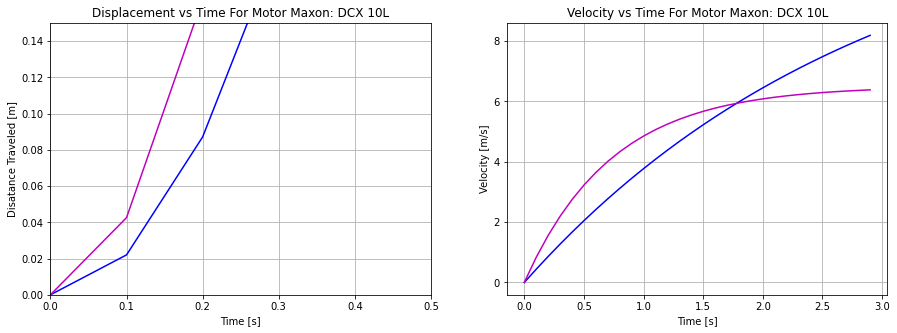

To reach a linear velocity of 3m/s, I need and angular velocity of 300.0 given a wheel radius 1.0cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



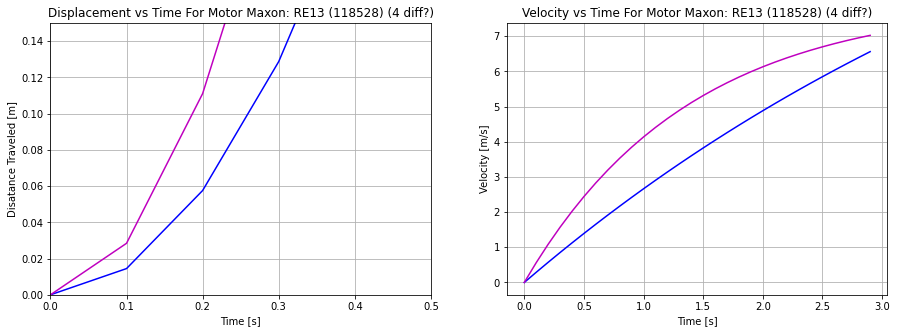

To reach a linear velocity of 3m/s, I need and angular velocity of 260.9 given a wheel radius 1.1cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



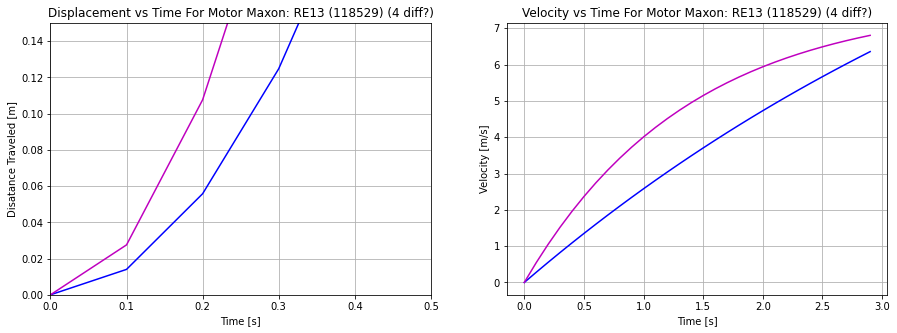

To reach a linear velocity of 3m/s, I need and angular velocity of 260.9 given a wheel radius 1.1cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



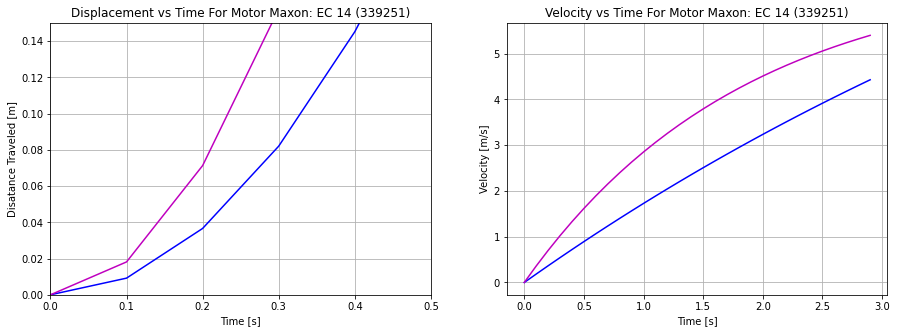

To reach a linear velocity of 3m/s, I need and angular velocity of 260.9 given a wheel radius 1.1cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



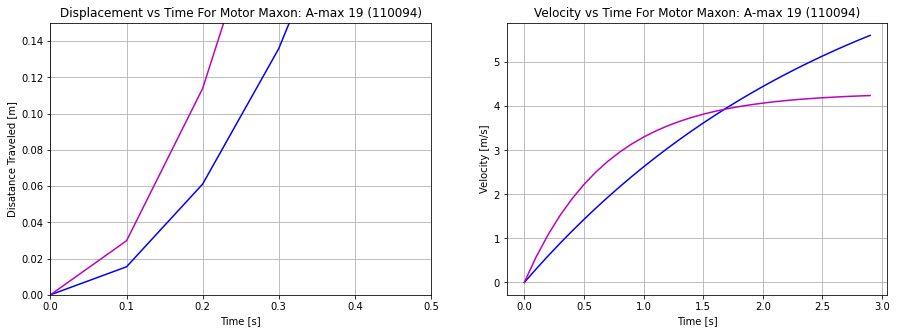

To reach a linear velocity of 3m/s, I need and angular velocity of 206.9 given a wheel radius 1.5cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



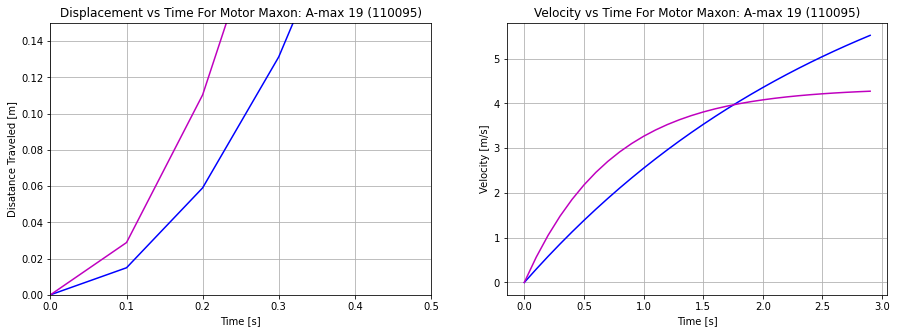

To reach a linear velocity of 3m/s, I need and angular velocity of 206.9 given a wheel radius 1.5cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



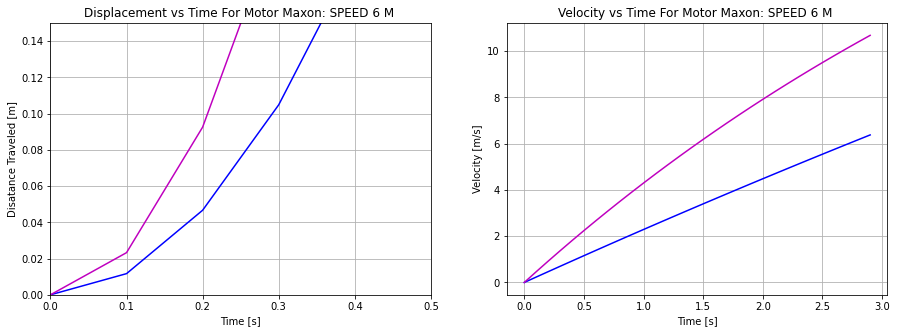

To reach a linear velocity of 3m/s, I need and angular velocity of 375.0 given a wheel radius 0.8cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



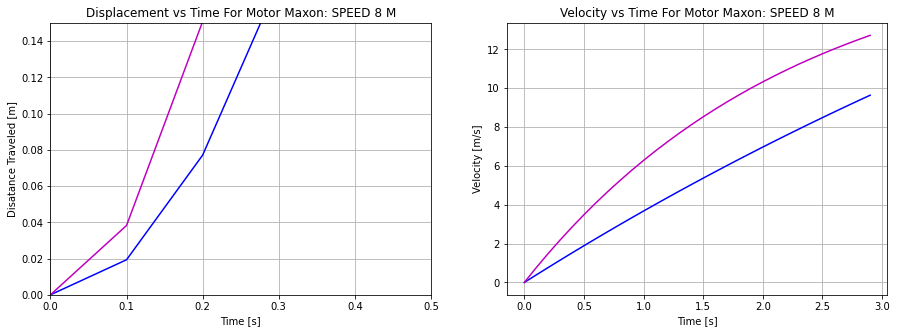

To reach a linear velocity of 3m/s, I need and angular velocity of 333.3 given a wheel radius 0.9cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



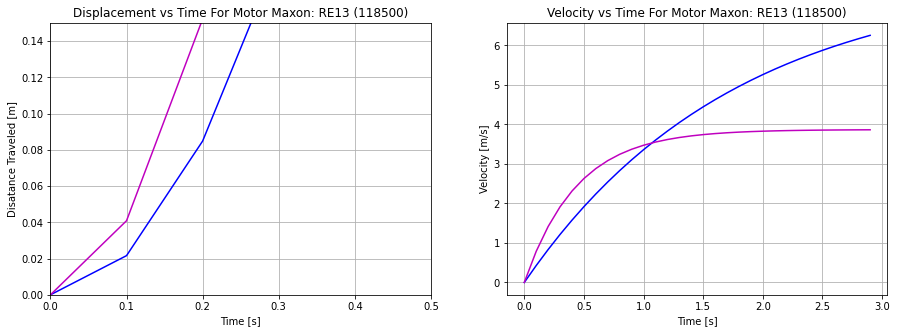

To reach a linear velocity of 3m/s, I need and angular velocity of 260.9 given a wheel radius 1.1cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



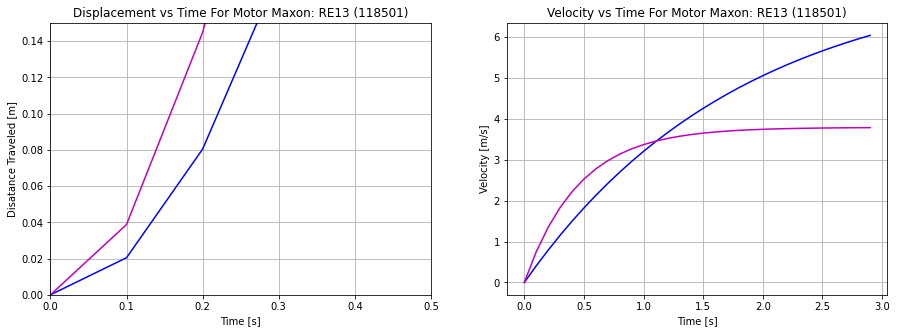

To reach a linear velocity of 3m/s, I need and angular velocity of 260.9 given a wheel radius 1.1cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



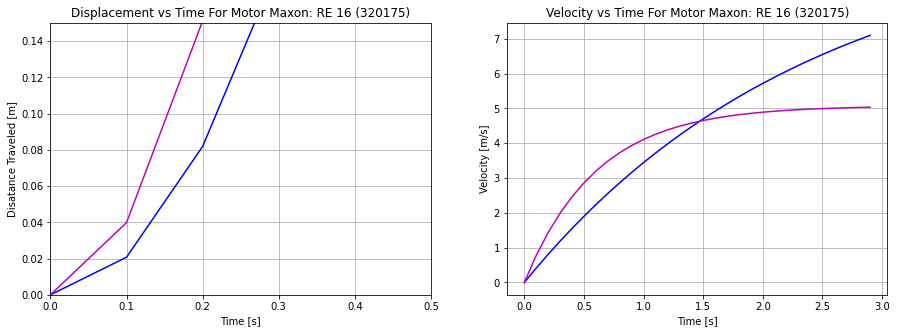

To reach a linear velocity of 3m/s, I need and angular velocity of 230.8 given a wheel radius 1.3cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



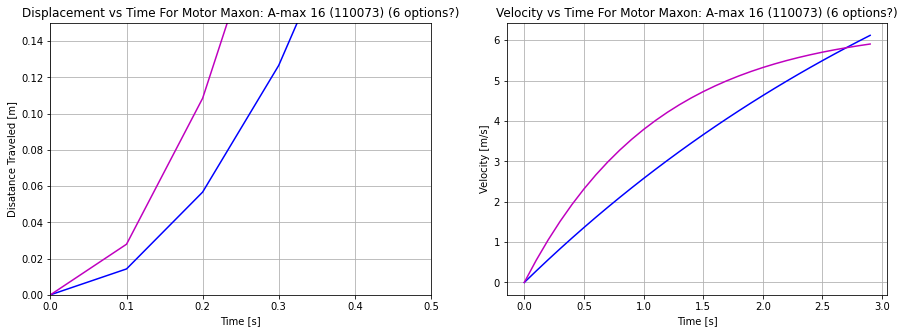

To reach a linear velocity of 3m/s, I need and angular velocity of 230.8 given a wheel radius 1.3cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



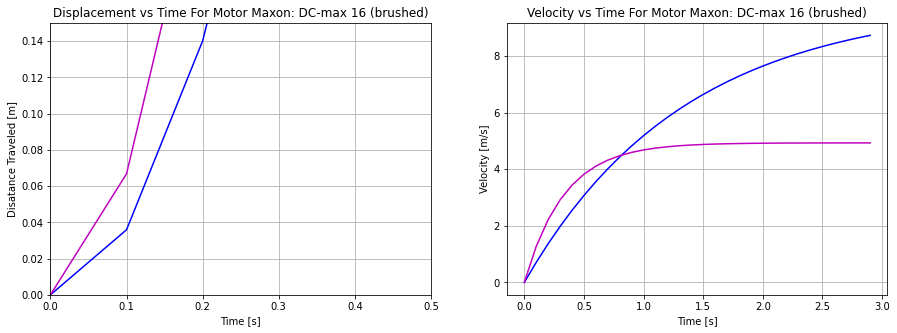

To reach a linear velocity of 3m/s, I need and angular velocity of 230.8 given a wheel radius 1.3cm
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



In [5]:
# Plot 1.5W Motors #
G1 = 1
G2 = 2
    
for i in range(len(all_motor_name_15W)): 
    motor_diam_15W = all_motor_diam_15W[i]
    kt_15W = all_motor_kt_15W[i]
    single_motor_m_15W = all_single_motor_weight_15W[i]
    input_V_15W = all_nominal_V_15W[i]
    motor_R_15W = all_motor_R_15W[i]
    motor_stall_t_15W = all_motor_stall_t_15W[i]
    motor_no_load_RPM_15W = all_motor_no_load_RPM_15W[i]
    
    no_load_w_15W = (2*math.pi*motor_no_load_RPM_15W) / 60
    
    motor_rad_15W = (motor_diam_15W / 2) 
    wheel_rad_15W = (motor_rad_15W + 5) / 1000

    displacement1 = disp_simulation(kt_15W, G1, single_motor_m_15W, input_V_15W, motor_R_15W, wheel_rad_15W)
    displacement2 = disp_simulation(kt_15W, G2, single_motor_m_15W, input_V_15W, motor_R_15W, wheel_rad_15W)
    
    vel1 = vel_simulation(kt_15W, G1, single_motor_m_15W, input_V_15W, motor_R_15W, wheel_rad_15W)
    vel2 = vel_simulation(kt_15W, G2, single_motor_m_15W, input_V_15W, motor_R_15W, wheel_rad_15W)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(time, displacement1, '-b')
    ax1.plot(time, displacement2, '-m')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Disatance Traveled [m]')
    ax1.grid(b=None, which='both', axis='both')
    ax1.set_ylim(bottom= 0, top = tile_len+0.05)
    ax1.set_xlim(left= 0, right = 0.5)
    ax1.set_title(f'Displacement vs Time For Motor {all_motor_name_15W[i]}')
    
#     ax2.plot([0, motor_stall_t_15W*G1], [no_load_w_15W / G1, 0], "-b")
#     ax2.plot([0, motor_stall_t_15W*G2], [no_load_w_15W / G2, 0], "-m")
#     ax2.grid(b=None, which='both', axis='both')
#     ax2.set_xlabel('Torque [mNm]')
#     ax2.set_ylabel('Radial Velocity [rad / s]')
#     ax2.set_title(f'Torque-Speed Curve For {all_motor_name_15W[i]}')

    ax2.plot(time, vel1, '-b')
    ax2.plot(time, vel2, '-m')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Velocity [m/s]')
    ax2.grid(b=None, which='both', axis='both')
#     ax2.set_ylim(bottom= 0, top = tile_len+0.05)
#     ax2.set_xlim(left= 0, right = 0.5)
    ax2.set_title(f'Velocity vs Time For Motor {all_motor_name_15W[i]}')

    plt.show()
    
    v_lin = 3
    w_3ms = v_lin / wheel_rad_15W
    
    print(f"To reach a linear velocity of {v_lin}m/s, I need and angular velocity of {round(w_3ms, 1)} given a wheel radius {round(wheel_rad_15W*100, 1)}cm")
    print("_________________________________________________________________________________________________________________")
    print("_________________________________________________________________________________________________________________\n")

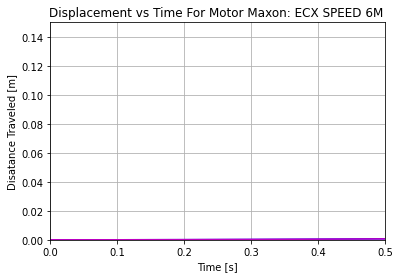

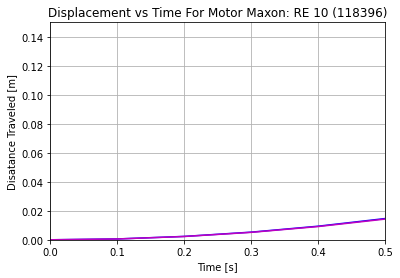

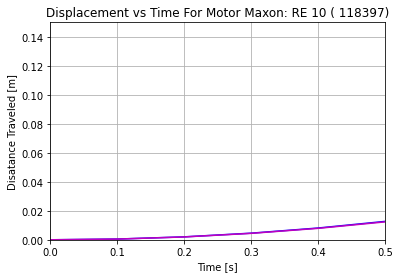

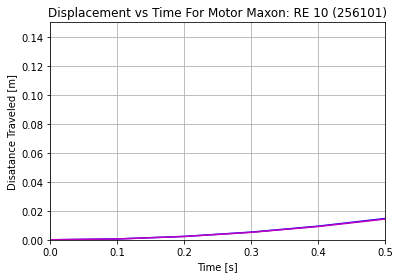

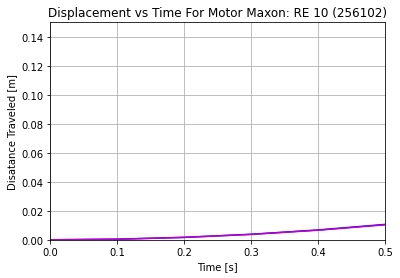

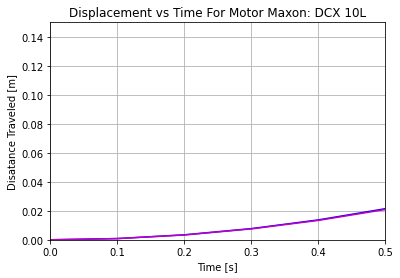

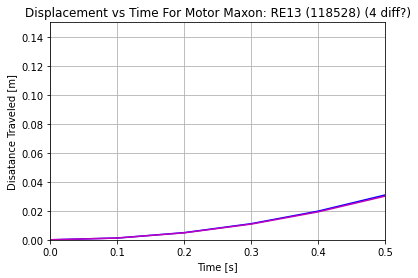

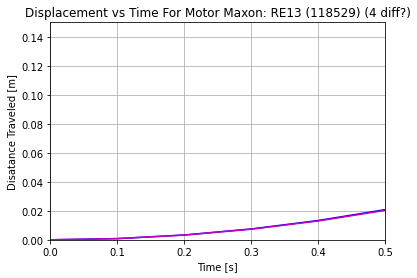

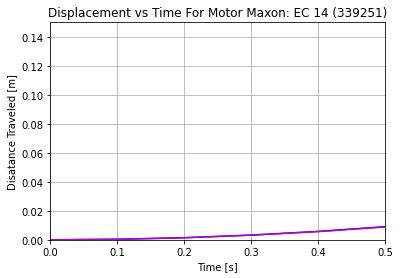

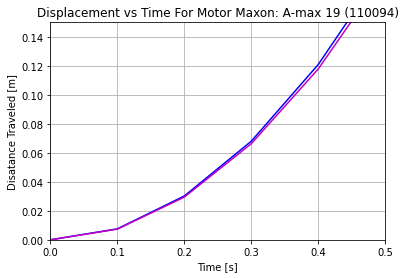

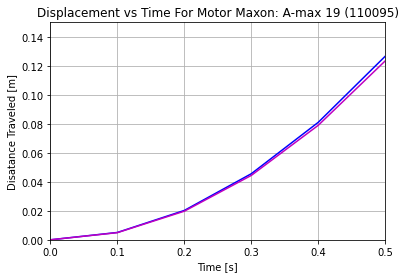

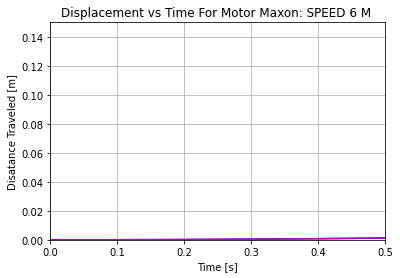

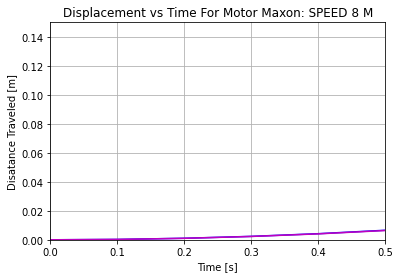

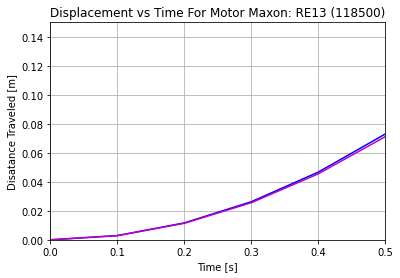

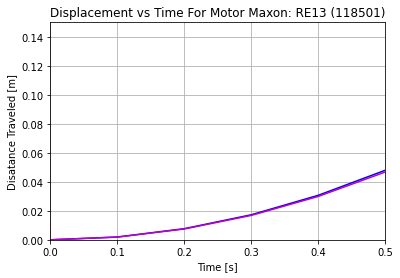

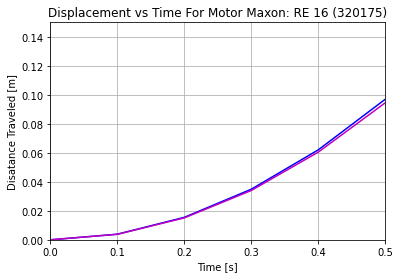

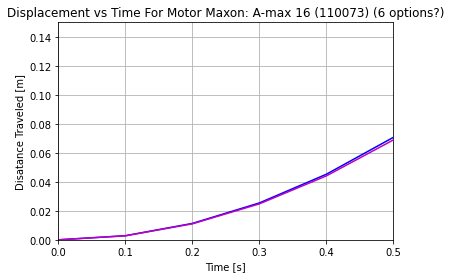

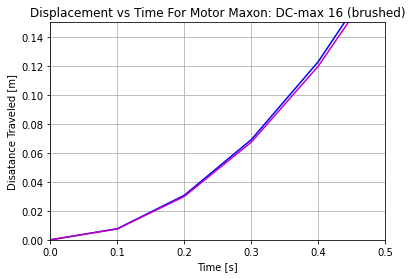

In [6]:
# Plot 2W Motors #
G3 = 1
G4 = 2
    
for i in range(len(all_motor_name_2W)): 
    motor_diam_2W = all_motor_diam_2W[i]
    kt_2W = all_motor_kt_2W[i]
    single_motor_m_2W = all_single_motor_weight_2W[i]
    input_V_2W = all_nominal_V_2W[i]
    motor_R_2W = all_motor_R_2W[i]

    displacement3 = disp_simulation(motor_diam_2W, kt_2W, G3, single_motor_m_2W, input_V_2W, motor_R_2W)
    displacement4 = disp_simulation(motor_diam_2W, kt_2W, G4, single_motor_m_2W, input_V_2W, motor_R_2W)
    
    fig, ax2 = plt.subplots()
    ax2.plot(time, displacement3, '-b')
    ax2.plot(time, displacement4, '-m')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Disatance Traveled [m]')
    ax2.grid(b=None, which='both', axis='both')
    ax2.set_ylim(bottom= 0, top = tile_len+0.05)
    ax2.set_xlim(left= 0, right = 0.5)
    
    plt.title(f'Displacement vs Time For Motor {all_motor_name_2W[i]}')
    plt.show()

## I know we dont have a constant acceleration, but lets express the relationship between acceleration and torque


Given the formulas...

$F = ma$

$\tau = Fr$

We can say that...

$\tau = mar$

We can graph the simple relationship between torque and  acceleration. 

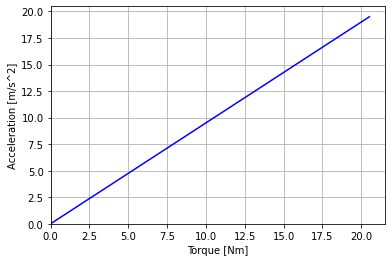

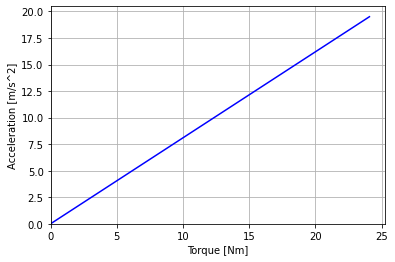

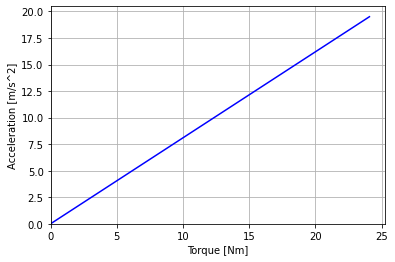

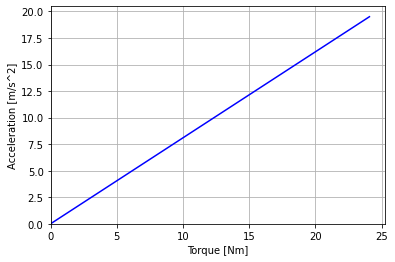

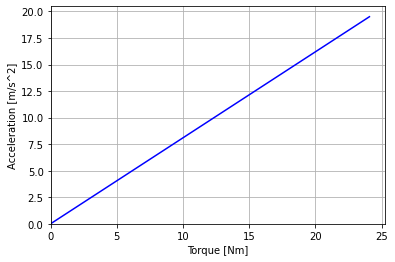

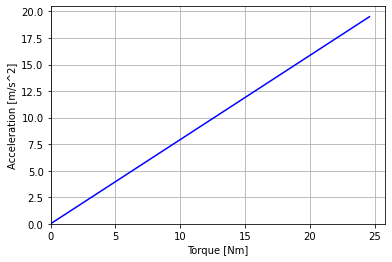

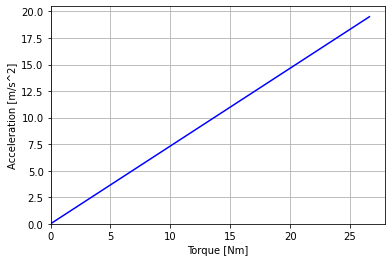

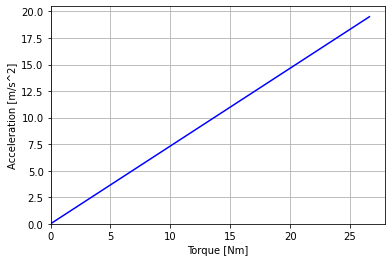

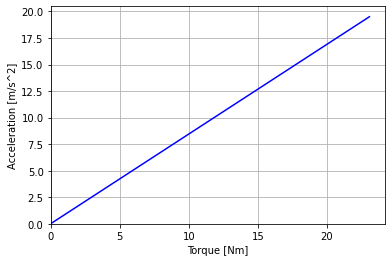

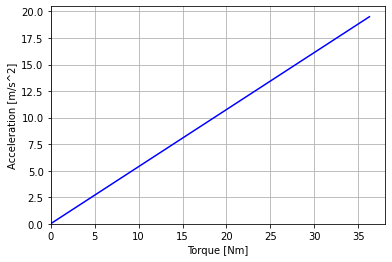

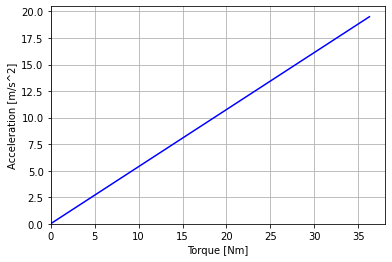

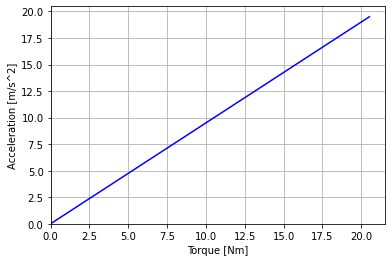

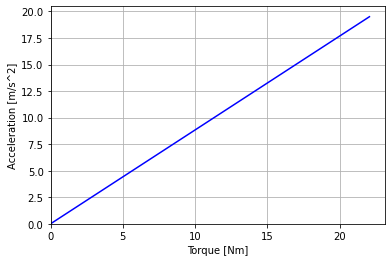

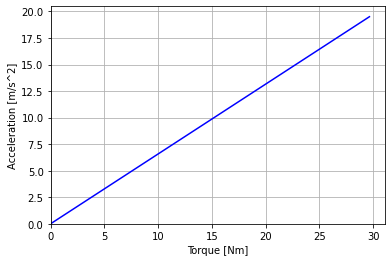

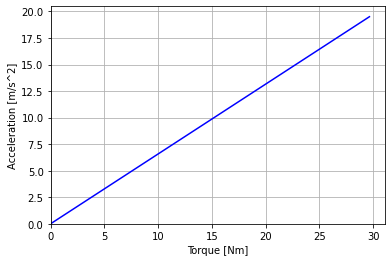

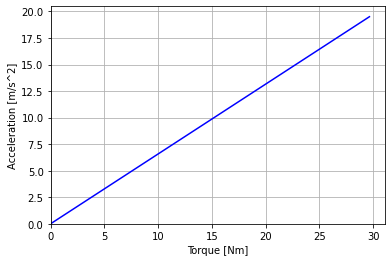

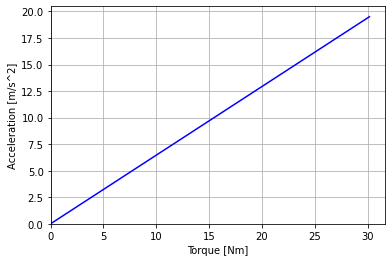

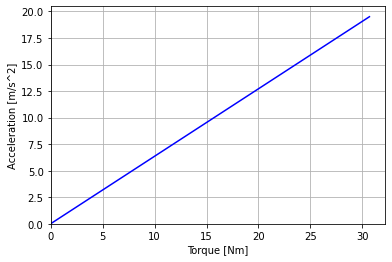

In [7]:
accel = np.arange(0, 20, 0.5)

for i in range(len(all_motor_name_15W)): 
    torque = []
    motor_diam_15W = all_motor_diam_15W[i]
    single_motor_m_15W = all_single_motor_weight_15W[i]
    
    no_load_w_15W = (2*math.pi*motor_no_load_RPM_15W) / 60
    
    motor_r_15W = (motor_diam_15W / 2) 
    wheel_r_15W = (motor_rad_15W + 5) / 1000
    
    m_battery_g = 50
    m_controller = 10
    m_encoder = 5
    m_other = 10
    mass = ((single_motor_m_15W*2) + m_battery_g + m_controller + m_encoder +  m_other) / 1000
    
    for a in accel: 
        t = mass * a * wheel_r_15W
        torque.append(t*1000)
        
    fig, ax3 = plt.subplots()
    ax3.plot(torque, accel, '-b')
    ax3.set_ylabel('Acceleration [m/s^2]')
    ax3.set_xlabel('Torque [Nm]')
    ax3.grid(b=None, which='both', axis='both')
    ax3.set_ylim(bottom= 0)
    ax3.set_xlim(left= 0)

    

## Battery Calculations 

The battery I've been modeling with is rated at a capactiy of 950mAh, V = 7.4 and C = 25 constant, 50 burst. 

https://hobbyking.com/en_us/turnigy-nano-tech-950mah-2s-25-50c-lipo-pack.html?queryID=1eaac594597e79e054b2ad91f52d2667&objectID=47397&indexName=hbk_live_magento_en_us_products

At shortest time and maximum current draw:

$60min / 25C = 2.4 min$

$I = 0.95(25) = 23.75 A$

From our previous discussions, we said that given a 45min - 1hour experiment, we can predict that a battery should last on average at least 15 minutes. So for 15 minutes...

$60min / 15min = 4C$

For 4C, I can draw up to... 

$I = .95(4) = 3.8A$

### Simple Mechanical Calculations:

The simpliest spec we can calculate first is a maximum angular velocity. What angular speed would we need to operate at in order to achieve a linear speed of 3 m/s?

Given the equation $v = \omega r$ we can determine that for the maximum angular velocity, $\omega$, we need to use the smallest possible radius $r$. 

Most motors have a diamter of 10mm (1 cm) or above, so lets assume a smallest wheel radius to be 6mm (0.6cm) so we can safety algin the motor with the wheels. 

#### Solving for $\omega$ ...

$\omega_\max = \frac{v}{r} = \frac{3 m/{s}^2}{0.006m} = 500 rad/s$


In [8]:
v_max = 3
r_min = 0.006

omega_max = v_max / r_min

print(f"Maximum angular speed is {omega_max} rad/s")

Maximum angular speed is 500.0 rad/s


#### Converting to RMP...

$RPM_\max = \frac{60\omega}{2\pi} = \frac{60(500)}{2\pi} = 4,775$

All the Maxon motors I looked at easily meet this maximum RPM requirment, which is great because it means we can adjust the wheel radius to be larger if need be. The larger the wheel radius, the less RPM the motors need to procude to drive at a linear speed of 3m/s. However, speed and torque have an inverse relationship which needs to be taken into consideration when deciding on radius size and motor selection. 

In [9]:
RPM_max = (60*omega_max) / (2*math.pi)
print(f"Maximum angular speed is {RPM_max} RPM")

Maximum angular speed is 4774.64829275686 RPM


### Now that we have a gauge on our velocity needs, lets take a look at average accelertation. 

Given what we know, we can use an energy calulcation for a quick, back of the envelope means to determine a maximum *constant* acceleration. 

First we'll need to calculate a total mass for the robot. The lighter motors I found were around 10g each. The lightest battery I found is a little less than 50g, so we'll assume 50g for now. If I account for the extra equipment I'll have to use, such as PCB, controllers and other peripherials, its reasonable to assume the smallest mass I can acheieve is around 100g or 0.1kg. 

Lighter motors can only output so much power, so most of the motors that meet our weight requirments are rated between 1.5W and 3W. 

Using the equation for the average change in kinetic energy $\Delta KE = \frac{1}{2}m{v_f}^2 - \frac{1}{2}m{v_0}^2$ and we assume to start from rest, we can say that the change in energy is equal to $\frac{1}{2}m{v_f}^2$

Power is the change in energy over time, making $P = \frac{\frac{1}{2}m{v_f}^2}{t}$

#### Solving for time to determine the minimum time to reach 3m/s...

$t_\min = \frac{\frac{1}{2}m{v_f}^2}{P}$

#### Solving for the acceleration that can be achieved in that time...

$a_\max = \frac{v_\max}{t_\min}$

For the 1.5W motors, let assume a combined power of two motors is 3W. And for the 2W motors, let assume a combined power of 4W.Therefore...

In [10]:
m_grams = 50 + (10*2) + 30
m_kg = m_grams / 1000

power1 = 3

KE = (0.5*(m_kg)*(v_max*v_max))

t_min1 = KE / power1

a_max1 = v_max / t_min1

x_min1 = v_max / a_max1

power2 = 4

t_min2 = KE / power2

a_max2 = v_max / t_min2

x_min2 = v_max / a_max2

print(f"Maximum acceleration is {a_max1} m/s^2 over a time of {t_min1} s for a combined power of {power1}W")
print(f"This max accleration will cover a distance of {x_min1}m\n")

print(f"Maximum acceleration is {a_max2} m/s^2 over a time of {t_min2} s for a combined power of {power2}W")
print(f"This max accleration will cover a distance of {x_min2}m")

Maximum acceleration is 20.0 m/s^2 over a time of 0.15 s for a combined power of 3W
This max accleration will cover a distance of 0.15m

Maximum acceleration is 26.666666666666664 m/s^2 over a time of 0.1125 s for a combined power of 4W
This max accleration will cover a distance of 0.11250000000000002m


# Now that we have a max *constant* acceleration for any motor, lets narrow down the acceleration using torque


So above we calculated a constant accleration as a function of the energy needed to move our robot of a set mass to 3m/s. This yeilded the highest acceleration in the shortest amount of time. But that those calculations dont take into account any motor parameters, aside from max mechanical power.

Given that power is a function of torque an angular velocity for each motor, it would probably be better to determine a max power based on those motor characteristics. Below I derive how to calculate the max feasible acceleration as a function of the motor's power, torque and angular velcoity. 

$P = \tau\omega$

$\omega = \frac{v}{r}$

$\tau = Fr = mar$

$P = (mar)(\frac{v}{r})$

$P = mav$

$a = \frac{P}{mv}$


With these equations in mind, I found that the maximum feasible acceleration for a total power of 4W (2 motors @ 2W ea.) is around 13 $m/{s}^2$. This tracks closesly the micromouse acclerations I found, which seem to be between 5 and 10 $m/{s}^2$. Any more and we may run into issues with the robot tipping backwards from accerlation or slipping. 

For now, lets test the highest acceleration, a middle acceleration and a lowest acceleration and compare the time it takes to reach these acclerations as well as the ditances traveled to achieve a velocity of 3m/s from rest. 

In [11]:
a1 = power2 / (m_kg*v_max)
a2 = 10
a3 = 8

t1 = v_max / a1
t2 = v_max / a2
t3 = v_max / a3

x1 = (v_max*v_max) / (2*a1)
x2 = (v_max*v_max) / (2*a2)
x3 = (v_max*v_max) / (2*a3)

tile_corner_len = 0.12
tile_edge_len = 0.10

tile_count1 = x1 / tile_edge_len
tile_count2 = x2 / tile_edge_len
tile_count3 = x3 / tile_edge_len

print(f"TO REACH A VELOCITY OF {v_max} m/s...")
print(f"With an acceleration of {round(a1, 1)} m/s^2, it takes {round(t1, 1)}s and we will travel {x1}m or {tile_count1} tiles")
print(f"With an acceleration of {a2} m/s^2, it takes {t2}s and we will travel {x2}m or {tile_count2} tiles")
print(f"With an acceleration of {a3} m/s^2, it takes {t3}s and we will travel {x3}m or {tile_count3} tiles")

TO REACH A VELOCITY OF 3 m/s...
With an acceleration of 13.3 m/s^2, it takes 0.2s and we will travel 0.3375m or 3.375 tiles
With an acceleration of 10 m/s^2, it takes 0.3s and we will travel 0.45m or 4.5 tiles
With an acceleration of 8 m/s^2, it takes 0.375s and we will travel 0.5625m or 5.625 tiles


Playing with acclerations has showed me that we have a tricky situation here. All other considerations aside, I'd love to have the highest acceleration possible, in order to cover the smallest distance in the least amount of time to reach our veclocity goal. However I'm just not sure whats realistic and what accelerations are going to be so high that they cause tipping / slipping issues. 

**Is traveling 0.5m before reaching a top speed of 3m/s too far? The habitat is only 3m at its longest point.** 

Lets try playing with a lower velocities below:

In [12]:
# v1 = 2.5 
# v2 = 2.25
# v3 = 2

# t1_1 = v1 / a1
# t1_2 = v1 / a2
# t1_3 = v1 / a3
# x1_1 = (v1*v1) / (2*a1)
# x1_2 = (v1*v1) / (2*a2)
# x1_3 = (v1*v1) / (2*a3)

# t2_1 = v2 / a1
# t2_2 = v2 / a2
# t2_3 = v2 / a3
# x2_1 = (v2*v2) / (2*a1)
# x2_2 = (v2*v2) / (2*a2)
# x2_3 = (v2*v2) / (2*a3)

# t3_1 = v3 / a1
# t3_2 = v3 / a2
# t3_3 = v3 / a3
# x3_1 = (v3*v3) / (2*a1)
# x3_2 = (v3*v3) / (2*a2)
# x3_3 = (v3*v3) / (2*a3)

# print(f"FOR VELOCITY {v1} m/s")
# print(f"To reach acceleration {a1}m/s^2, takes {t1_1}s and we will travel {x1_1}m")
# print(f"To reach acceleration {a2}m/s^2, takes {t1_2}s and we will travel {x1_2}m")
# print(f"To reach acceleration {a3}m/s^2, takes {t1_3}s and we will travel {x1_3}m\n")

# print(f"FOR VELOCITY {v2} m/s")
# print(f"To reach acceleration {a1}m/s^2, takes {t2_1}s and we will travel {x2_1}m")
# print(f"To reach acceleration {a2}m/s^2, takes {t2_2}s and we will travel {x2_2}m")
# print(f"To reach acceleration {a3}m/s^2, takes {t2_3}s and we will travel {x2_3}m\n")

# print(f"FOR VELOCITY {v3} m/s")
# print(f"To reach acceleration {a1}m/s^2, takes {t3_1}s and we will travel {x3_1}m")
# print(f"To reach acceleration {a2}m/s^2, takes {t3_2}s and we will travel {x3_2}m")
# print(f"To reach acceleration {a3}m/s^2, takes {t3_3}s and we will travel {x3_3}m\n")

#### Time to play with torque

Alright so we have some basic speed and accleration data which means we can spec out some potential torque values. With approximate speed and torque values, I can create a Speed vs Torque graph and start to reason which motors fit our requirements. 

Given the formulas...

$F = ma$

$\tau = Fr$

We can say that...

$\tau = mar$

<!-- Given that we have a minimum radius of 6mm and assuming we use the minimum acceleration of 5 $m/{s}^2$ we can calculate and absolute minimum torque needed to move the robot. 

**WE SHOULD ADD FRICTION TO THIS LATER** -->

In [13]:
torque_min = m_kg * a3 * r_min

print(f"Minimum torque for an acceleration of {a3} is {round(torque_min * 1000, 1)} mNm")

Minimum torque for an acceleration of 8 is 4.8 mNm


Alright, so minimum torque is a start, but hopefully we'll be using at least a higher accleration than 5 $m/{s}^2$. 

Lets test for the higher accelerations, while still using the minimum radius

In [14]:
# DOWNLOADS FOR MOUSE DATA
# % reset -f
import requests
# from google.colab import files
 

def cast(s):
    cf = True
    try:
        float(s)
    except ValueError:
        cf = False
    ci = True
    if cf:
        try:
            ci = int(s) == float(s)
        except ValueError:
            ci = False
    else:
        ci = False

    if ci:
         return int(s)
    if cf:
         return float(s)
    return s

def download (url, path = None):
    web_get = requests.get(url)
    if not path:
        path = url.split("/")[-1]
    with open(path, "wb") as f:
        f.write(web_get.content)
 


#download modules
download("https://github.com/germanespinosa/images/raw/master/map.py")
download("https://github.com/germanespinosa/images/raw/master/display.py")
download("https://github.com/germanespinosa/images/raw/master/world.py")
download("https://github.com/germanespinosa/images/raw/master/heat_map.py")
download("https://github.com/germanespinosa/images/raw/master/web_resources.py")
download("https://github.com/germanespinosa/images/raw/master/visibility.py")
download("https://github.com/germanespinosa/images/blob/master/data.json?raw=true", "data.json")
download("https://maciver-lab.github.io/plangame/maps/savanna.json")

#configure font
import matplotlib.font_manager as fm
 
download("https://github.com/germanespinosa/images/raw/master/Myriad%20Pro%20Regular.ttf","Myriad-Pro-Regular.ttf")
prop = fm.FontProperties(fname="Myriad-Pro-Regular.ttf")
fm.fontManager.addfont("Myriad-Pro-Regular.ttf")
font_name = prop.get_name()


[0, 0.5813638038073233, 0.1917259266367291, 1.1062725469273227, 1.373764282021924, 1.2190068850216138, 0.9487834643111205, 1.3099658022417275, 1.1615079819771186, 0.7586575500670266, 0.877081154469667, 0.9903776676875425, 1.3665966243077226, 1.2261050209263968, 0.9750783579239076, 0.9396508848297697, 1.384888116858625, 1.6397608390100527, 1.3075181710434634, 1.8640438782941473, 1.5056669617005338, 2.027082754327877, 2.083586522159531, 1.5471523251269252, 1.9308379403439457, 1.4634967650405182, 1.7343280275437971, 1.1965379300652066, 0.7120771269643452]


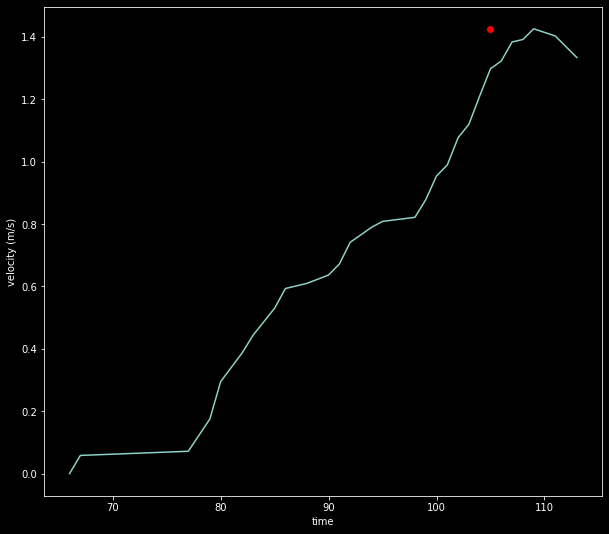

In [15]:
#RAW COORDINATE TEST
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import math
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
from world import World

world_name = "hexa_10_05"
file_name = "20210423_1520_FMM1_10_05_test.json"

w = World(world_name)
x = []
y = []
c = []
for cell in w.cells:
    x.append(cell["location"]["x"])
    y.append(cell["location"]["y"])
    c.append("white" if cell["occluded"] == 0 else "black")

y = [y*math.sqrt(3) for y in y]
plt.style.use("dark_background")

# fig, ax = plt.subplots(1, 1, figsize=(10, 9))
# plt.scatter(x, y, c=c, alpha=1,  marker="h", s=825)

f = open(file_name)
data = json.load(f)
cmap=plt.get_cmap('jet')
color_index = np.linspace(0, 1,len(data))

# ax.set_title(name)
for j in (data['episodes']):
    count = 0
    x_coord=[]
    y_coord=[]
    distance = []
    velocity = []
    time = []
    frame =[]
    first_coord = [j['trajectories'][0]['location']['x'],
                j['trajectories'][0]['location']['y']]
    first_frame = j['trajectories'][0]['frame']
    previous_coord = first_coord
    previous_frame = first_frame
    previous_dist = 0

    fx = -1000
    fy = -1000
    i =1
    for y in (j['trajectories']):
        new_coord = [y['location']['x'],
                      y['location']['y']]

        time.append(y['frame']*(1/15))
        frame.append(y['frame'])

        if fx == -1000:
            fx = new_coord[0]
        if fy == -1000:
            fy = new_coord[1]
        fx = fx * (1-i) + new_coord[0] * i
        fy = fy * (1-i) + new_coord[1] * i
        x_coord.append(fx)
        y_coord.append(fy)
        step_dist = math.sqrt((new_coord[0]-previous_coord[0])**2 + (new_coord[1]-previous_coord[1])**2)
        step_dist_meter = 2.34/(220*20)*step_dist*220*20
        step_time = (y['frame']-previous_frame)*(1/15)

        total_distance = previous_dist + step_dist
        distance.append(total_distance)
        if step_time == 0:
            velocity.append(0)
        else:
            velocity.append(step_dist_meter/step_time)
        count = count + 1;
        previous_frame = y['frame']
        previous_coord = new_coord
        previous_dist = total_distance
        
y_coord_hex = [y*200*20-(200*20)/2 for y in y_coord]
x_coord_hex = [(1-x)*220*20-(220*20)/2 for x in x_coord]
print(velocity)

max_velocity = max(velocity)
max_index = velocity.index(max_velocity) 

#PLOT VELOCITIES OVER TIME
fig2, ax2 = plt.subplots(figsize=(10, 9))

v2=[]
i = (.1)
nv = 0
for v in velocity:
    nv = nv * (1-i) + v * i
    v2.append (nv)

plt.plot(frame,v2)

ax2.set_ylabel('velocity (m/s)')
ax2.set_xlabel('time')
plt.scatter(frame[max_index],max(v2),color='r')


## Robot velocity, take derivative of x(t) equation. 

Given the displacement vs time equation from before...

$x(t) = \frac{rV( {(k_t G)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - 1))}{{(k_t G)}^3}$

Take the derivative of that equation to find the realtionship of velocity vs time. Lets start by rearranging it a bit.

$x(t) = \frac{rV}{{(k_t G)}^3}({(k_t G)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - 1))$

$x(t) = \frac{rV}{{(k_t G)}^3}({(k_t G)}^2 t + Rm{r}^2 {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - Rm{r}^2)$

Now lets take the derivative with respect to $t$...

$x'(t) = \frac{rV}{{(k_t G)}^3} ({(k_t G)}^2 + Rm{r}^2 \frac{{(-k_t G)}^2}{Rm{r}^2} {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

$x'(t) = \frac{rV}{{(k_t G)}^3} ({(k_t G)}^2 -{{(k_t G)}^2} {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

In [16]:
# time = np.arange(0,3,0.1)
# tile_len = 0.1

# def vel_simulation(kt, G, single_motor_m, input_V, motor_R, wheel_rad):
#     # wheel_rad in mm
#     # kt in mNm/A
#     # Motor mass in g (add battery and peripherail mass)
#     # input V in Volts
#     # Motor R in ohms
    
#     vel = []
    
#     m_battery_g = 50
#     m_controller = 10
#     m_encoder = 5
#     m_other = 10
#     m_kg = ((single_motor_m*2) + m_battery_g + m_controller + m_encoder +  m_other) / 1000
    
#     ktG = (kt / 1000) * G
#     rV = wheel_rad * input_V
#     Rmr2 = motor_R * m_kg * math.pow(wheel_rad, 2)
    
#     for t in time:
#         ktG2 = (math.pow(ktG, 2))
#         ktG2t = ktG2  * t
#         expon = math.exp( -ktG2t / Rmr2)
    
#         v_t = (rV / (math.pow(ktG, 3))) * (ktG2 - (ktG2 * expon))
#         vel.append(v_t)
        
#     return vel
    